In [52]:
import numpy
import imageio
import scipy.special
import matplotlib.pyplot

class NumbersRecognition:
    # инициализировать нейронную сеть
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        # задать количество узлов во входном, скрытом и выходном слоях
        self.i_nodes = input_nodes
        self.h_nodes = hidden_nodes
        self.o_nodes = output_nodes
        
        # Матрицы весовых коэффициентов связей w_ih (между входным и скрытым слоями) и w_ho (между скрытым и выходным слоями).

        # w_ih is a matrix (h_nodes, i_nodes), where number of rows = h_nodes, and number of columns = i_nodes.
        # ==> in current test the matrix is (100, 784), where number of rows = 100 and number of columns = 784.
        self.w_ih = numpy.random.normal(0.0, pow(self.h_nodes, -0.5), (self.h_nodes, self.i_nodes))
        
        # w_ho is a matrix (o_nodes, h_nodes), where number of rows = o_nodes, and number of columns = h_nodes.
        # ==> in current test the matrix is (10, 100), where number of rows = 10 and number of columns = 100.
        self.w_ho = numpy.random.normal(0.0, pow(self.o_nodes, -0.5), (self.o_nodes, self.h_nodes))
        
        # коэффициент обучения
        self.lr = learning_rate
        
        # использование сигмоиды в качестве функции активации
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        pass

    # тренировка нейронной сети
    def train(self, inputs_list, targets_list):
        
        # преобразование списка входных значений в двухмерный массив
        # .T is transpose of this matrix
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # рассчитать входящие и исходящие сигналы для скрытого слоя
        # numpy.dot returns the dot product of two arrays. For 2-D vectors, it is the equivalent to matrix multiplication.
        hidden_inputs = numpy.dot(self.w_ih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # рассчитать входящие и исходящие сигналы для выходного слоя
        final_inputs = numpy.dot(self.w_ho, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        # ошибки выходного слоя = (целевое значение - фактическое значение)
        output_errors = targets - final_outputs
        
        # ошибки скрытого слоя - это ошибки output_errors, распределенные пропорционально 
        # весовым коэффициентам связей и рекомбинированные на скрытых узлах
        hidden_errors = numpy.dot(self.w_ho.T, output_errors)
        
        # обновить веса для связей между скрытым и выходным слоями
        self.w_ho += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), 
                                         numpy.transpose(hidden_outputs))
        
        # обновить весовые коэффициенты для связей между входным и скрытым слоями
        self.w_ih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), 
                                         numpy.transpose(inputs))
        pass

    # опрос нейронной сети
    def query(self, inputs_list):
        
        # преобразовать список входных значений в двухмерный массив
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # рассчитать входящие и исходящие сигналы для скрытого слоя
        hidden_inputs = numpy.dot(self.w_ih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # рассчитать входящие и исходящие сигналы для выходного слоя
        final_inputs = numpy.dot(self.w_ho, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.w_ho.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.w_ih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

    pass

In [53]:
# read data from file
def read_file(path_to_file):
    file = open(path_to_file, 'r')
    data = file.readlines()
    file.close()
    return data

In [54]:
# метод для масштабирования и смещения входных значений
def scale_input_values(values):
    # деление исходных входных значений, изменяющихся в диапазоне (0 - 255), на 255 приведёт их к диапазону (0 - 1,0)
    # последующее умножение этих значений на 0,99 приведёт их к диапазону (0,0 - 0,99)
    # далее мы инкрементируем их на 0,01, чтоб вместить их в желаемый диапазон (0,01 - 1,0)
    return (numpy.asfarray(values) / 255.0 * 0.99) + 0.01

In [55]:
# количество входных, скрытых и выходных узлов
input_nodes = 784
hidden_nodes = 100
output_nodes = 10

# коэффициент обучения
learning_rate = 0.1

# создаём экземпляр нейронной сети
n = NumbersRecognition(input_nodes, hidden_nodes, output_nodes, learning_rate)

# загружаем в список тренировочный набор данных
training_data_list = read_file("mnist_dataset/mnist_train.csv")
#training_data_list = read_file("mnist_dataset/mnist_train_100.csv")

# train neural network

# переменная epochs указывает, сколько раз тренировочный тренировочный набор данных используется для тренировки нейронной сети
epochs = 5

for e in range(epochs):
    # перебрать все записи в тренировочном наборе данных
    for record in training_data_list:
        # получить список значений, используя символ "," в качестве разделителя
        all_training_values = record.split(',')
        # масштабировать и сместить входные значения
        scaled_inputs = scale_input_values(all_training_values[1:])
        # создать целевые выходные значения(все равны 0.01, за исключением маркерного значения)
        targets = numpy.zeros(output_nodes) + 0.01
        targets[int(all_training_values[0])] = 0.99
    
        n.train(scaled_inputs, targets)
        pass
    pass

In [8]:
# проверим роботу нейронки
test_data_list = read_file("mnist_dataset/mnist_test.csv")
#test_data_list = read_file("mnist_dataset/mnist_test_10.csv")

# журнал оценок работы сети, первоначально пустой
scorecard = []

# перебрать все записи в тестовом наборе
for record in test_data_list:
    # получить список значений из записи, исполььзуя в качестве разделителя символ запятой
    all_values = record.split(',')
    # правильный ответ - первое значение
    correct_lable = int(all_values[0])
    # масштабировать и сместить входные значения
    inputs = scale_input_values(all_values[1:])
    # опрос сети
    outputs = n.query(inputs)
    # индекс наибольшего значения является маркерным значением
    label = numpy.argmax(outputs)
    # в случае правильного ответа сети присоединить к списку значение 1, иначе - 0
    if (label == correct_lable):
        scorecard.append(1)
    else:
        scorecard.append(0)
        pass
    pass


In [9]:
#print(scorecard)
scorecard_array = numpy.asarray(scorecard)
print("Эффективность нейронной сети -", scorecard_array.sum() / scorecard_array.size)

Эффективность нейронной сети - 0.9696


In [56]:
img_array = imageio.imread("test_images/test3.png", as_gray=True)
img_data = 255.0 - img_array.reshape(784)
img_data = (img_data / 255.0 * 0.99) + 0.01

outputs = n.query(img_data)
label = numpy.argmax(outputs)
print("network says ", label)

network says  2


[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99]


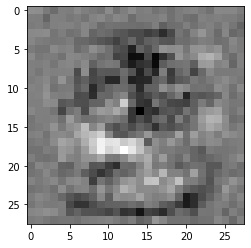

In [67]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 9
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')